In [16]:
import json
import re
import itertools
import os

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime
from collections import defaultdict

from sklearn import svm 
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold
import sklearn.model_selection as model_selection

from approximation_algorithm import create_pred_tdag

%matplotlib inline

In [18]:
df = pd.read_excel("../quantifiers_prep_matter_in_qsd.xls", index_col=0, header=0)

In [19]:
df.shape

(680, 5)

In [20]:
df.head()

,test.no,q.no,sent.no,sentences,scopes
case.no,,,,,
1,1,1,1.0,Exactly six&2_S_exactly.six.appositive# trade ...,b>a
2,1,1,2.0,There are exactly six&2_P_exactly.six# chairs ...,b>a
4,1,1,4.0,Each&1_S_each# chair is occupied by exactly on...,a>b
9,1,2,1.0,A&1_S_a# small software firm has four&2_O_four...,a>b
10,1,2,2.0,Each&1_S_each# of its offices has exactly one&...,"a>b,c"


In [21]:
# Some examples (to test functions):
test_annot = "Each&1_S_each# member of the Kim family sits in a&3_in_a_p.Locus_p.Locus# seat adjacent to, and in the same row&3_in_the.same_p.Locus_p.Locus# as, at least one other&2_as_at.least.one.other_p.ComparisonRef_p.ComparisonRef# member of the family."
test_scope = "a>d>b,c"

In [22]:
"""
Intitialize sets to store information.
Define some constants.
"""
R_GRAMM = ['S', 'O', 'IO', 'P', 'A', "'s"] # Gramamtical roles present in the corpus
ALL_LEX = set() # a set of all possible lexicalizations of quantifiers
ALL_ROLES = set() # should equal to the list 'R_GRAMM'
ALL_PREP = set() # a set of all prepositions in the corpus
ALL_SS2 = set() # a -||- ss2
ALL_SSSS2 = set() # a -||- ss+ss2 combinations

TRAIN_RATIO = 0.8
TEST_RATIO = 0.2

ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

# Feature extraction

In [23]:
"""
Fills in sets defined in the previous cell and returns a list of lists of annotations.

The beggining of each tag is marked with '&' and the end with '#'. 

First spot is occupied by a number that corresponds to the relative scope of a given quantifier in a given sentence.
Second spot is either a gramamtical role of a given tag or a preposition if a given tag is a prepositional phrase.
Third position representes the quantifier lexicalisation.
Fourth and fifth positions are present only if the phrase is a prepositional phrase and correspond to supersenses, SS 
and SS2 respectively.
"""

def extract_annotations(corpus_sentence):
    annotations = []
    i = 0
    p = re.compile(r'&.+?#') # Each tag starts with '&' and ends with '#'
    for m in re.finditer(p, corpus_sentence):
        annotation = m.group()[1:-1].split('_')
        # Temporal adjuncts such as 'Each day' are additionaly tagged in the corpus with supersenses p.Time_p.Time. 
        # We do not want to include those supersenses in the experiment since there is no explicit preposition here.
        if annotation[-1] == 'p.Time' and annotation[-2] == 'p.Time' and annotation[1] == 'A':
            annotation = annotation[:-2]
        
        if annotation[-1].startswith('p.'):
            ALL_SS2.add(annotation[-1])
            ALL_SSSS2.add(annotation[-2] + '_' + annotation[-1])
        if annotation[1] in R_GRAMM:
            ALL_ROLES.add(annotation[1])
        if annotation[1] not in R_GRAMM:
            ALL_PREP.add(annotation[1])
        
        ALL_LEX.add(annotation[2])
    
        # For each sentence and each quantifier (tag) in it add a letter at the end of the tag that will distinguish it
        annotation.append(ALPHABET[i])
        
        annotations.append(annotation)      
        i += 1
    return annotations

In [24]:
"""
Returns a list of lists of quantifier annotations.
"""

def annotations(data):
    all_annotations = []
    for index, row in data.iterrows():
        all_annotations.append(extract_annotations(row['sentences']))
    return all_annotations

### Create a list of annotations 

In [25]:
"""
Populate the list of lists representing quantifier annotations for each sentence.
"""
ALL_ANNOTATIONS = annotations(df)

## Corpus statistics

In [26]:
"""
This cell computes some corpus statistics
"""

nb_sent = 0 # Number of sentences in the corpus
nb_tags = 0 # Number of tags in the corpus
nb_tags_pp = 0 # Number of tags that are nested in prepositional phrases
nb_of_relations = 0 # Number of observations/relations
for sent in ALL_ANNOTATIONS:
    nb_of_relations += len(sent)*(len(sent)-1)/2
    nb_sent += 1
    for el in sent:
        nb_tags += 1
        if el[1] in ALL_PREP:
            nb_tags_pp += 1

print(
      ' Number of sentences in the corpus: ', nb_sent, '\n',
      'Number of tags in the corpus: ', nb_tags, '\n',
      'Number of tags in the corpus that are nested in prepositional phrases: ', nb_tags_pp, '\n',
      'Number of relations/observations: ', int(nb_of_relations)
)

 Number of sentences in the corpus:  680 
 Number of tags in the corpus:  1679 
 Number of tags in the corpus that are nested in prepositional phrases:  581 
 Number of relations/observations:  1451


In [27]:
"""
This cell presents some more corpus statistics.
"""

print(
    ' Number of different gramamtical roles annotated: ', len(ALL_ROLES), '\n',
    'Number of different quantifier lexicalisations: ', len(ALL_LEX), '\n',
    # Quantifier lexicalisations are later combined into groups
    'Number of different preposition lexicalisations: ', len(ALL_PREP), '\n',
    'Number of different ss2: ', len(ALL_SS2), '\n',
    'Number of different ss+ss2 combinations: ', len(ALL_SSSS2), '\n',
     
     )

 Number of different gramamtical roles annotated:  6 
 Number of different quantifier lexicalisations:  184 
 Number of different preposition lexicalisations:  27 
 Number of different ss2:  26 
 Number of different ss+ss2 combinations:  67 



# Graphs and scope extraction

In [28]:
"""
These three functions extract pairwise comparisons relations from sentence's scopings. 
An input is a sentence's scope (e.g. 'a>b>c,d').
Function 'extract_scopes' returns a set of nodes (quantifiers in a given sentence) and a set of outscoping relations. 
The set consists of tuples sorted such that if 'a>b' then '(a,b)' and if 'b>a' then '(b,a)'.
"""

def extract_scopes(scope):
    edges = []
    nodes = set()
    for i in range(len(scope)):
        if scope[i] == ">":
            edges.append((scope[i-1], scope[i+1]))
            if scope[i-2] == ",":
                ab = check_before(scope, i-1)
                edges.extend(ab)
            if i < len(scope)-2 and scope[i+2] == ",":
                af = check_after(scope, i+1)
                edges.extend(af)
        if scope[i].isalpha():
            nodes.add(scope[i])
    edges = set(edges)
    return nodes, edges

def check_before(scope, j):
    l = []
    for i in range(j):
        if scope[j-i] == ",":
            l.append((scope[j-i-1], scope[j+2]))
        elif scope[j-i] == ">" or scope[j-i] == ";":
            break
    return l

def check_after(scope, j):
    l = []
    for i in range(len(scope)-j):
        if scope[j+i] == ",":
            l.append((scope[j-2], scope[j+i+1]))
        elif scope[j+i] == ">" or scope[j+i] == ";":
            break
    return l

print(test_scope)
extract_scopes(test_scope)

a>d>b,c


({'a', 'b', 'c', 'd'}, {('a', 'd'), ('d', 'b'), ('d', 'c')})

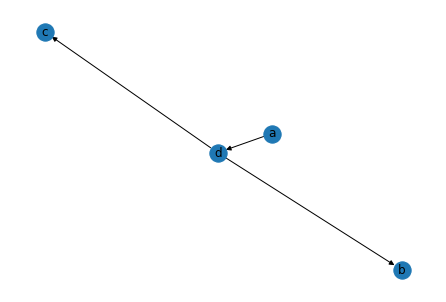

In [29]:
"""
Making use of the functions defined in the previous cell, this function returns a Directed Acylic Graph (DAG)
that represents each sentence's quantifier scoping.
"""
def build_dag(scope):
    nodes, edges = extract_scopes(scope)
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    if not nx.is_directed_acyclic_graph(G):
        print('STOP! This graph is not a DAG!')
    return G

G = build_dag(test_scope)
nx.draw(G, with_labels = True)

### Labels

Three classes that the classifier will predict: \
0 --> incomparability relation \
1 --> wide scope \
2 --> narrow scope

In [32]:
"""
Given the labels defined above, by taking the transitive closure of DAGs that represent each sentence's scoping, 
this function returns a dictionary where keys are tuples that correspond to a pair of quantifiers - an observation -
(always sorted as (q1, q2), where q1 occurs before q2 in a given sentence) and values are classes to be predicted: 
incomparability relation, wide scope or narrow scope.
"""

def graph_to_dict_closure(scope):
    G = build_dag(scope)
    G_closure = nx.transitive_closure(G)
    all_nodes = sorted(list(G_closure.nodes))
    all_edges = list(G_closure.edges)
    comparisons = {}
    for a, b in itertools.combinations(all_nodes, 2):
        if (a, b) in all_edges:
            comparisons[(a, b)] = '1' # wide scope
        elif (b, a) in all_edges:
            comparisons[(a, b)] = '2' # narrow scope
        else:
            comparisons[(a, b)] = '0' # if there is no edge then the two quantifiers are in an incomparability relation
    return comparisons
print(test_scope)
graph_to_dict_closure(test_scope)

a>d>b,c


{('a', 'b'): '1',
 ('a', 'c'): '1',
 ('a', 'd'): '1',
 ('b', 'c'): '0',
 ('b', 'd'): '2',
 ('c', 'd'): '2'}

In [33]:
"""
Return a list of dictionaries where each dictionary lists pairs of quantifiers from a sentence and relations between 
those pairs.
"""

def scopes(data):
    all_scopes = []
    for index, row in data.iterrows():
            all_scopes.append(graph_to_dict_closure(row['scopes']))
    return all_scopes

### Create a list of scopes

In [36]:
"""
Populate the list of lists representing quantifier annotations for each sentence.
"""
ALL_SCOPES = scopes(df)

In [37]:
"""
This cell computes population of classes.
"""

wide = 0
narrow = 0
incomp = 0
for el in ALL_SCOPES:
    for k, v in el.items():
        if v == '0':
            incomp += 1
        elif v == '1':
            wide += 1
        else:
            narrow += 1
print(
      ' Number of wide scopes: ', wide, '\n',
      'Number of narrow scopes: ', narrow, '\n',
      'Number of incomparability relations: ', incomp, '\n',
)

 Number of wide scopes:  828 
 Number of narrow scopes:  307 
 Number of incomparability relations:  316 



## Define data split

In [42]:
"""
Models are trained multiple times with different train/test splits. 
This is why random state is the argument of the function.

Note, however, that even though an observation in this experiment is a pair of quantifiers, the data needs to be split
on a sentence level so that all observations (pairs of quantifiers) from the same sentence are located in the same data set.
This way it is possible to restore the sentence's quantifier scoping once the predictions of the classifier are made.
"""

def split_data(X_data, y_data, r_state):
    train_annot, test_annot, train_scope, test_scope = model_selection.train_test_split(X_data, y_data,
                                                                                        train_size = TRAIN_RATIO,
                                                                                        test_size = TEST_RATIO,
                                                                                        random_state = r_state)
    return train_annot, train_scope, test_annot, test_scope

## Extract features

In [43]:
# Feature: COMPLEX
"""
A binary feature; a quantifier lexicalization is cosidered complex if it cosists of more than one word (e.g. 'more than one')
('.appositive' refers to a different feature which was annotated in the corpus together with quantifier lexicalization)

"""
def is_complex(lexicalization):
    if lexicalization.endswith('.appositive'): 
        lexicalization = lexicalization[:-len('.appositive')]
    return 1. if len(lexicalization.split('.')) > 1 else 0.

print(is_complex('more.than.one'))
print(is_complex('each.appositive'))

1.0
0.0


In [44]:
# Feature: APPOSITIVE
"""
A binary feature; denotes whether a quantified NP chunk is followed by an appositive.
"""

def appositive(lexicalization):
    feature = 0.
    if lexicalization.endswith('.appositive'):
        feature = 1.
    return feature

print(appositive('some.appositive'))
print(appositive('every'))

1.0
0.0


In [45]:
# Feature: DISTANCE
"""
Distance between the two compared quantifiers.  Equals 1 if no quantifier is between two compared 
quantifiers in the sentence.

For instance, in 'b>c>a' there are three observations for the classifier: (a,b), (a,c) and (b,c). 
The distance for the observations (a,b) and (b,c) equals 1. 
The distance in the case of observation (a,c) equals 2.
"""

def distance(sentence_annotation, first, second):
    f = sentence_annotation.index(first)
    s = sentence_annotation.index(second)
    result = float(s - f) 
    return result

distance(ALL_ANNOTATIONS[4], ALL_ANNOTATIONS[4][0], ALL_ANNOTATIONS[4][2])

2.0

In [46]:
# Feature: Quantifier lexicalization
"""
Combines many of the quantifier lexicalisations into groups (in order to lower the dimensionality of this feature).
For instance, all bare numerals are grouped together, all superlative modified numerals together, etc.
"""

numerals = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 
                'therteen', 'fourteen']
the_numerals = ['the.' + n for n in numerals]
consecutive_numerals = [n + '.consecutive' for n in numerals]

def del_appositive(lex):
    if lex.endswith('.appositive'): 
        lex = lex[:-len('.appositive')].lower()
    return lex

def prep_lex(all_lex):
    all_lex_mod = []
    for lex in list(all_lex):
        lex = del_appositive(lex)
        all_lex_mod.append(lex.lower())
    return all_lex_mod

def assign_group_lex(lex):
    lex = lex.lower()
    if lex.startswith('exactly'):
        result = 'exactly.numerals'
    elif lex.startswith('at.least') or lex.startswith('at.most'):
        result = 'smn'
    elif lex in numerals:
        result = 'bare.numerals'
    elif lex in the_numerals:
        result = 'the.numerals'
    elif lex in consecutive_numerals:
        result = 'consecutive.numerals'
    elif lex.startswith('more.than') or lex.startswith('no.more.than') or lex.startswith('less.than'):
        result = 'cmn'
    elif lex.startswith('the.'):
        result = 'definites'
    elif lex == 'an':
        result = 'a'
    else:
        result = lex
    return result


def combine_lexicalizations(all_lex_mod):
    all_lex_comb = set()
    for lex in all_lex_mod:
        all_lex_comb.add(assign_group_lex(lex.lower()))
    return list(all_lex_comb)

        
# This funciton is to encode quantifier lexicalisations into a binary feature      
def extract_lex(lex, le, nr_r):
    colnr = le.transform([lex])[0]
    lex_vector = np.zeros((nr_r))
    lex_vector[colnr] = 1.
    return lex_vector

In [47]:
"""
This funciton is to encode grammatical roles and preposition lexicalisation or preposition supersenses into binary features
"""

def extract(annot, le, nr_r, opt):
    colnr = 999
    if opt == 'ss2' and annot[-2].startswith('p.'):
        colnr = le.transform([annot[-2]])[0]
    elif opt == 'ssss2' and annot[-2].startswith('p.'):
        colnr = le.transform([annot[-3] + '_' + annot[-2]])[0]
    elif opt == 'prep' and annot[1] not in R_GRAMM:
        colnr = le.transform([annot[1]])[0]
    elif opt == 'roles' and annot[1] in R_GRAMM:
        colnr = le.transform([annot[1]])[0]
    
    roles_vector = np.zeros((nr_r))
    if colnr != 999:
        roles_vector[colnr] = 1.  
    return roles_vector

In [48]:
"""
This function, given certain options e.g. whether to encode preposition lexicalizations or preposition supersenses,
returns: a list with feature names, feature vector and a vector of the target variable.
"""
def prep_data(data_annotations, data_scopes, roles, quant_lex, prep, super_ss2, super_ssss2):

# Create an instance of an encoder of gramamtical roles and take the number of elements in that list
    le_roles = preprocessing.LabelEncoder()
    le_roles.fit(list(roles))
    nr_roles = len(list(roles))
    
# Set possible label encoders of preposition features to  False. Depending on a condition (e.g. model with preposition
# lexicalizations only) those will be later changed to label encoders
    le_prep = False
    le_super_ss2 = False
    le_super_ssss2 = False
    
# Delete '.appositive' from quantifier lexicalizations list
    lex_mod = prep_lex(quant_lex)

# Group quantifier lexicalizations
    lex_mod_group = combine_lexicalizations(lex_mod)

# Create an instance of an encoder of grouped quantifier lexicalizations
    le_lex_group = preprocessing.LabelEncoder()
    le_lex_group.fit(lex_mod_group)
    nr_lex_group = len(lex_mod_group)

# Initialize an instance of preposition lexicalizations encoder
# Set 'prep' to False if you don't want to include preposition lexicalizations in the experiment
    if prep:
        if not prep == ALL_PREP:
            print('STOP! Something is wrong here!')          
        le_prep = preprocessing.LabelEncoder()
        le_prep.fit(list(prep))
        nr_prep = len(list(prep))

# Initialize an instance of preposition supersenses SS2 encoder
# Set 'super_ss2' to False if you don't want to include preposition supersenses (SS2) in the experiment
    if super_ss2:
        if not super_ss2 == ALL_SS2:
            print('STOP! Something is wrong here!')
        le_super_ss2 = preprocessing.LabelEncoder()
        le_super_ss2.fit(list(super_ss2))
        nr_super_ss2 = len(list(super_ss2))

# Initialize an instance of preposition supersenses SS->SS2 combinations encoder.
# Set 'super_ssss2' to False if you don't want to include preposition supersenses (SSSS2) in the experiment
    if super_ssss2:
        if not super_ssss2 == ALL_SSSS2:
            print('STOP! Something is wrong here!')
        le_super_ssss2 = preprocessing.LabelEncoder()
        le_super_ssss2.fit(list(super_ssss2))
        nr_super_ssss2 = len(list(super_ssss2)) 


# Initilize a list of feature vectors and a list of classes to be predicted
    x = []; y = []

# Iterate over each sentence's annotation and that sentence's corresponding scope
    for scopes, sentence_annotations in zip(data_scopes, data_annotations):
# Iterate over each pair of annotations 
        for s, z in itertools.combinations(sentence_annotations, 2):
            
# Encode feature COMPLEX
            is_comp_1 = is_complex(s[2])
            is_comp_2 = is_complex(z[2])

# Encode feature APPOSITIVE
            app_1 = appositive(s[2])
            app_2 = appositive(z[2])

# Encode feature DISTANCE. Note that unlike other features, distance in calculated only once since it is 
# a feature of the relaction between quantifiers in a pair (not a property of each quantifier separately)
            dist = distance(sentence_annotations, s, z)

# Encode the fourth feature - grammatical roles of a given tag
            extr_roles_1 = extract(s, le_roles, nr_roles, 'roles')
            extr_roles_2 = extract(z, le_roles, nr_roles, 'roles')

# Statements below encode preposition information into feature vectors

# Initialie arrays of preposition features (either lexicalizations or supersenses); for BASELINE, for instance, none of
# those arrays will be populated.
            extr_prep_1 = np.array([])
            extr_prep_2 = np.array([])
                
            extr_super_ss2_1 = np.array([])
            extr_super_ss2_2 = np.array([])
            
            extr_super_ssss2_1 = np.array([])
            extr_super_ssss2_2 = np.array([])
                
# Encode info about preposition lexicalizations
            if prep:
                extr_prep_1 = extract(s, le_prep, nr_prep, 'prep')
                extr_prep_2 = extract(z, le_prep, nr_prep, 'prep')

# Encode info about preposition supersenses SS2
            if super_ss2:
                extr_super_ss2_1 = extract(s, le_super_ss2, nr_super_ss2, 'ss2')
                extr_super_ss2_2 = extract(z, le_super_ss2, nr_super_ss2, 'ss2')

# Encode info about preposition supersenses SSSS2
            if super_ssss2:             
                extr_super_ssss2_1 = extract(s, le_super_ssss2, nr_super_ssss2, 'ssss2')
                extr_super_ssss2_2 = extract(z, le_super_ssss2, nr_super_ssss2, 'ssss2')

# Encode information about grouped quantifier lexicalizations
            extr_lex_group_1 = extract_lex(assign_group_lex(del_appositive(s[2])),
                                                         le_lex_group, nr_lex_group)
            extr_lex_group_2 = extract_lex(assign_group_lex(del_appositive(z[2])),
                                                         le_lex_group, nr_lex_group)
            
# Combine feature vectors into one feature vector          
            feature_vector = np.concatenate(([is_comp_1], [app_1], extr_roles_1, extr_lex_group_1,
                                             extr_prep_1, extr_super_ss2_1, extr_super_ssss2_1,
                                             [dist],
                                             [is_comp_2], [app_2], extr_roles_2, extr_lex_group_2, 
                                             extr_prep_2, extr_super_ss2_2, extr_super_ssss2_2), 
                                             axis=0)
    
# Last character of an annotation (e.g. s[-1]) is a letter of the alphabat that identifies each annotation
# The scopes are encoded with alphabet letters as well
            quantifier_1 = s[-1]
            quantifier_2 = z[-1]
        
# It cannot happen that (label_1, label_2) are not in scopes.keys(); it would mean there is an
# error somewhere
            if (quantifier_1, quantifier_2) not in scopes.keys():
                print('STOP! Something is wrong here!')  
            
# Extract class label of a given observation and append it to a list
            y.append(scopes[(quantifier_1, quantifier_2)])
    
# Append feature vector of a given observation to a list
            x.append(feature_vector)
            
# Create a list of feature names in the same order in which they appear in the feature vector
# This step is necessary for the feature importance analysis
    colnames = ['complex_1', 'appositive_1']
    for colname in list(le_roles.classes_): colnames.append(colname + '_1')
    for colname in list(le_lex_group.classes_): colnames.append(colname + '_1')
    if le_prep:
        for colname in list(le_prep.classes_): colnames.append(colname + '_1')
    if le_super_ss2:
        for colname in list(le_super_ss2.classes_): colnames.append(colname + '_1')
    if le_super_ssss2:
        for colname in list(le_super_ssss2.classes_): colnames.append(colname + '_1')
    colnames.append('distance')
    colnames.extend(['complex_2', 'appositive_2'])
    for colname in list(le_roles.classes_): colnames.append(colname + '_2')
    for colname in list(le_lex_group.classes_): colnames.append(colname + '_2')
    if le_prep:
        for colname in list(le_prep.classes_): colnames.append(colname + '_2')
    if le_super_ss2:
        for colname in list(le_super_ss2.classes_): colnames.append(colname + '_2')
    if le_super_ssss2:
        for colname in list(le_super_ssss2.classes_): colnames.append(colname + '_2')
            
    x = np.array(x) ; y = np.array(y)

    return colnames, x, y

### Test functions

In [49]:
train_annot_r, train_scope_r, test_annot_r, test_scope_r = split_data(ALL_ANNOTATIONS, ALL_SCOPES, 0)
colnames, X_test_r, y_test_r = prep_data(test_annot_r, test_scope_r, ALL_ROLES, ALL_LEX, ALL_PREP, False, False)
_, X_train_r, y_train_r = prep_data(train_annot_r, train_scope_r, ALL_ROLES, ALL_LEX, ALL_PREP, False, False)

In [50]:
m1 = svm.SVC()
m_fit = m1.fit(X_train_r, y_train_r)
pred_test = m_fit.predict(X_test_r)
print(accuracy_score(pred_test, y_test_r))

0.7391304347826086


# Feature importance and selection

In [54]:
"""
This function returns (saves to a png file) Feature Importance analysis of 18 most relevant features. Corresponds to Figure 3
from the paper.
"""

def feature_importance(number_feat, file_name, vert):
    
    cols, d_X, d_y = prep_data(ALL_ANNOTATIONS, ALL_SCOPES, ALL_ROLES, ALL_LEX, ALL_PREP, ALL_SS2, ALL_SSSS2)
    
    mi_results = mutual_info_classif(d_X, d_y, discrete_features = True)

    mi_results_sorted, colnames_sorted = (list(t) for t in zip(*sorted(zip(mi_results, cols), reverse = True)))

    cols_sorted_renamed = []
    for col in colnames_sorted:
        if col.split('_')[0] in ALL_SS2 and len(col.split('_')) < 3:
            cols_sorted_renamed.append(col.split('.')[1])
        elif len(col.split('_')) > 2 and col.split('_')[0] + '_' + col.split('_')[1] in ALL_SSSS2: 
            cols_sorted_renamed.append(col.split('_')[0].split('.')[1] + '.' + col.split('_')[1].split('.')[1] + 
                                     '_' + col.split('_')[2])
        elif col.split('_')[0] == 'O':
            cols_sorted_renamed.append('object' + '_' + col.split('_')[1])
        elif col.split('_')[0] == 'S':
            cols_sorted_renamed.append('subject' + '_' + col.split('_')[1])
        else:
            cols_sorted_renamed.append(col)

    if vert:
        y_pos = np.arange(len(cols_sorted_renamed))
        plt.figure(figsize=(6,6))
        #plt.title(figure_name)
        plt.yticks(y_pos[:number_feat], cols_sorted_renamed[:number_feat][::-1])
        plt.barh(range(len(mi_results_sorted[:number_feat])), mi_results_sorted[:number_feat][::-1], color="steelblue",
             align="center")
        plt.ylabel('Features')
        plt.xlabel('Mutual information')
    else:
        x_pos = np.arange(len(cols_sorted_renamed))
        plt.figure(figsize=(6,6))
            #len(colnames_sorted)-number_feat
        plt.xticks(x_pos[:number_feat], cols_sorted_renamed[:number_feat], rotation = 45, ha = 'right', fontsize = 12)
        plt.bar(range(len(mi_results_sorted[:number_feat])), mi_results_sorted[:number_feat], color="steelblue", align="center")
        #plt.xlabel('Features')
        plt.ylabel('Mutual Information', fontsize=12)
    plt.savefig(file_name, bbox_inches = "tight")
    plt.show()

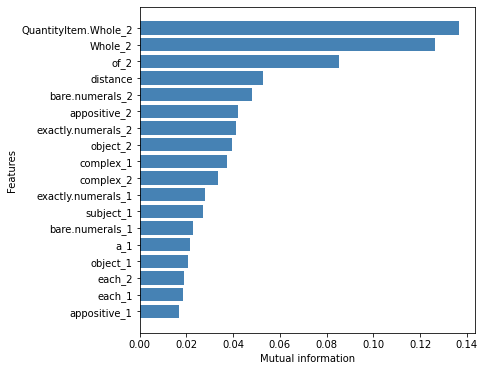

In [68]:
"""
Runs Feature Importance analysis
"""
file_name = 'Feature Importance/Figure 3'
if not os.path.exists(file_name.split('/')[0]):
    os.mkdir(file_name.split('/')[0])
feature_importance(18, file_name, True)

In [69]:
"""
Computes mutual information and frequency of features for the feature selection
"""
def mutual_info(d_X, d_y):
    mi_results = mutual_info_classif(d_X, d_y, discrete_features = True)
    freq = np.array([sum(feat) for feat in d_X.T]) 
    return mi_results, freq

In [70]:
"""
Returns an array of indexes of features that are supposed to be dropped because their mutual information is either zero or
their frequency is lower than 2.
"""

def features_to_drop(X_data, y_data):
    mi_results, freq = mutual_info(X_data, y_data)
    idx_to_drop_1 = np.where(mi_results == 0) # covers also features which frequency equals zero
    idx_to_drop_2 = np.where(freq == 1)
    features_to_drop = np.unique(np.concatenate((idx_to_drop_1[0], idx_to_drop_2[0])))
    return features_to_drop

## Approximation algorithm and Evaluation

In [71]:
# Predict probabilities with a default classifier just to test functions below with those predictions.
m1 = svm.SVC(probability = True, random_state = 1)
m_fit = m1.fit(X_train_r, y_train_r)
pred_test_proba = m_fit.predict_proba(X_test_r)

In [72]:
"""
Returns a list of dictionaries where each dictionary represents pairs of quantifiers (keys; tuple) and predicted class
probabilities for those pairs (values; list) for each sentence.
"""
def get_prob_dict(test_data_annot, test_data_scope, test_pred):
    results = []
    beg = 0 
    end = int((len(test_data_annot[0])*(len(test_data_annot[0]) - 1))/2)
    for i in range(len(test_data_scope)):
        sent_pred = test_pred[beg:end]
        slownik = {k:list(sent_pred[j]) for (k, v), j in zip(test_data_scope[i].items(), range(len(test_data_scope[i])))}
        results.append(slownik)
        beg = end
        if i < len(test_data_scope)-1:
            end += len(test_data_annot[i+1])*(len(test_data_annot[i+1])-1)/2
            end = int(end)
    return results
d_test = get_prob_dict(test_annot_r, test_scope_r, pred_test_proba)
d_test[0]

{('a', 'b'): [0.05963306634841424, 0.9127323905808155, 0.027634543070770044]}

## Create gold and predicted graphs

In [73]:
"""
Returns gold transitive directed acyclic graph.
"""
def create_nx_gold_tdag(scope):
    G = nx.DiGraph()
    for key, value in scope.items():
        G.add_node(key[0])
        G.add_node(key[1])
        if value == str(1) or value == 1:
            G.add_edge(key[0], key[1])
        elif value == str(2) or value == 2:
            G.add_edge(key[1], key[0])
    G_test = nx.transitive_closure(G)
    if not nx.is_isomorphic(G, G_test):
        print("STOP! This should not have happened")
    return G

In [74]:
"""
Given a list of nodes and a list of edges returned by the approximation algorithm, this function returns an instance
of a prediced transitive directed acyclic graph created with the module NetworkX.
"""

def create_nx_pred_tdag(pred_sent):
    nodes, edges = create_pred_tdag(pred_sent)
    tdag_pred = nx.DiGraph()
    for node in nodes:
        tdag_pred.add_node(node)  
    for edge in edges:
        tdag_pred.add_edge(edge[0], edge[1])   
    return tdag_pred

### Evaluation metrics

In [75]:
"""
Functions defined in this cell are responsible for computing evalutation metric: similarity.
"""

# Similarity measure for a sentence's scope
def sort_edges(g_edges):
    g_edges_final = []
    for edge in g_edges:
        if edge[0] > edge[1]:
            g_edges_final.append((edge[1], edge[0]))
        else:
            g_edges_final.append(edge)
    return g_edges_final

def eval_similar(g_pred, g_gold):
    m1 = len(set(g_pred.edges).intersection(set(g_gold.edges)))
    g_pred_comp_und = nx.complement(g_pred.to_undirected())
    g_gold_comp_und = nx.complement(g_gold.to_undirected())
    
    # When we get an undirected version of a graph, it does not matter if edges are in order (q1, q2) or (q2, q1). 
    # However, they need to be in the same order in the case of gold graph and predicted graph.
    g_gold_comp_und_edges_sorted = sort_edges(g_gold_comp_und.edges)
    g_pred_comp_und_edges_sorted = sort_edges(g_pred_comp_und.edges)
    
    m2 = len(set(g_pred_comp_und_edges_sorted).intersection(set(g_gold_comp_und_edges_sorted)))
    
    if not len(g_pred.nodes) == len(g_gold.nodes):
        print('STOP! Something is wrong here!')
        
    tot_edges = len(g_gold.nodes) * (len(g_gold.nodes) - 1)/2
    
    eval_similar = (m1 + m2) / tot_edges
    
    return eval_similar

# Similarity measure for the whole development or test set
def tot_eval_similar(sent_pred, dev_test_scope):
    tot_similar_score = 0
    for sent_p, sent_g in zip(sent_pred, dev_test_scope):
        G_pred = create_nx_pred_tdag(sent_p)
        G_gold = create_nx_gold_tdag(sent_g)
        s = eval_similar(G_pred, G_gold)
        tot_similar_score += s
    if not len(dev_test_scope) == len(sent_pred):
        print('STOP! Something is wrong here!')        
    similarity = tot_similar_score/len(dev_test_scope) * 100
    return similarity

In [76]:
"""
Functions defined in this cell are responsible for computing evalutation metrics: precision and recall.
"""

# Precision and recall for a sentence's scope
def eval_prec_recall(g_pred, g_gold):
    if not len(g_pred.nodes) == len(g_gold.nodes):
        print('STOP! Something is wrong here!')
    
    empty = False
    
    m1 = len(set(g_pred.edges).intersection(set(g_gold.edges)))
    
    m_precision = len(set(g_pred.edges))
    m_recall = len(set(g_gold.edges))

# There are sentences in the corpus with no intercation relation between quantifiers only. There are no edges in the graph
# representation of those sentences. Hence, we do not include those sentences in the computation of precision and recall.
# Also, it might be the case for a sentence that a gold scoping has edges but predicted scoping does not. Those sentence's
# are also not considered in computation of precision so that both precision and recall are computed on the same number
# of sentences.

    if m_precision == 0 or m_recall == 0:
        precision = 0
        recall = 0
        empty = True
    else:
        precision = m1/m_precision
        recall = m1/m_recall
    
    return precision, recall, empty


# Precision and recall measures for the whole development or test set
def tot_prec_rec(sent_pred, dev_test_scope):
    tot_precision = 0
    tot_recall = 0
    no_edges_sent = 0
    for sent_p, sent_g in zip(sent_pred, dev_test_scope):
        G_pred = create_nx_pred_tdag(sent_p)
        G_gold = create_nx_gold_tdag(sent_g)
        p, r, empt = eval_prec_recall(G_pred, G_gold)
        if empt:
            no_edges_sent += 1
        tot_precision += p
        tot_recall += r

    if not len(dev_test_scope) == len(sent_pred):
        print('STOP! Something is wrong here!')  
        
    precision_final = tot_precision/(len(dev_test_scope) - no_edges_sent) * 100
    recall_final = tot_recall/(len(dev_test_scope) - no_edges_sent) * 100
    return precision_final, recall_final

### Test functions

In [79]:
cols, data_X, data_y = prep_data(ALL_ANNOTATIONS, ALL_SCOPES, ALL_ROLES, ALL_LEX, ALL_PREP, False, False)
idx_drop = features_to_drop(data_X, data_y)

print(X_train_r.shape)
X_train_rrr = np.delete(X_train_r, idx_drop, axis = 1)
X_test_rrr = np.delete(X_test_r, idx_drop, axis = 1)

m2 = svm.SVC(probability = True, random_state = 1)
m_fit_proba = m2.fit(X_train_rrr,  y_train_r)
pred_test_proba = m_fit_proba.predict_proba(X_test_rrr)

prob_dict = get_prob_dict(test_annot_r, test_scope_r, pred_test_proba)
print(tot_eval_similar(prob_dict, test_scope_r))
print(tot_prec_rec(prob_dict, test_scope_r))

(1152, 237)
78.57843137254903
(84.48571428571428, 87.95238095238095)


### WIDE results

In [80]:
"""
This functions returns a dict with an information of most frequent label in the training set in all 30 different data splits.
In all 30 cases it is wide scope.
"""

def check_most_frequent(data_annots, data_scopes):
    most_freq_dict = defaultdict(int)
    most_freq_dict[0] = 0
    most_freq_dict[1] = 0
    most_freq_dict[2] = 0
    nb_outer = 30
    for i in range(nb_outer):
        train_annot, train_scope, _, _ = split_data(data_annots, data_scopes, i)
        wide = 0
        narrow = 0
        incomp = 0
        for sent in train_scope:
            for key, value in sent.items():
                if value == '1':
                    wide += 1
                elif value == '2':
                    narrow += 1
                else:
                    incomp += 1
        most_freq_class = [incomp, wide, narrow].index(max([incomp, wide, narrow]))
        most_freq_dict[most_freq_class] += 1
    return most_freq_dict

check_most_frequent(ALL_ANNOTATIONS, ALL_SCOPES)

defaultdict(int, {0: 0, 1: 30, 2: 0})

In [81]:
"""
This function converts list of scopes into the most frequent label - wide scope.
"""
def convert_to_wide(data_scopes):
    all_scopes_wide = []
    for sent in data_scopes:
        d = {}
        for key, value in sent.items():
            d[key] = 1
        all_scopes_wide.append(d)
    return all_scopes_wide

In [82]:
"""
This function provides results of the WIDE measure (as defined in the paper) that is a pseudo-model that labels each
pairwise comparison as the most frequent label - wide scope.
"""

def eval_wide_baseline(all_annot, all_scope):
    nb_outer = 30
    results = defaultdict(list)
    for i in range(nb_outer):
        tot_similar = 0
        tot_prec = 0
        tot_rec = 0
        no_edges = 0
        _, _, test_annot, test_scope = split_data(all_annot, all_scope, i)
        test_scope_wide = convert_to_wide(test_scope)
        for g_scope, w_scope in zip(test_scope, test_scope_wide):
            gold_graph = create_nx_gold_tdag(g_scope)
            wide_graph = create_nx_gold_tdag(w_scope)
            sim = eval_similar(gold_graph, wide_graph)
            prec, rec, empty = eval_prec_recall(gold_graph, wide_graph)
            tot_similar += sim
            tot_prec += prec
            tot_rec += rec
            if empty:
                no_edges += 1            
        
        final_sim = tot_similar/len(test_scope) * 100
        final_prec = tot_prec/(len(test_scope) - no_edges) * 100
        final_rec = tot_rec/(len(test_scope) - no_edges) * 100
        results['similarity'].append(final_sim)
        results['precision'].append(final_prec)
        results['recall'].append(final_rec)
    return results

results_wide = eval_wide_baseline(ALL_ANNOTATIONS, ALL_SCOPES)

In [83]:
similarity_results = (np.mean(results_wide['similarity']), np.std(results_wide['similarity']))
precision_results = (np.mean(results_wide['precision']), np.std(results_wide['precision']))
recal_results = (np.mean(results_wide['recall']), np.std(results_wide['recall']))
print('WIDE', '\n', 'similarity: ', similarity_results, 'precision: ', precision_results, 'recall: ', recal_results)

WIDE 
 similarity:  (64.82102007469653, 3.4649593128435696) precision:  (73.72693257625544, 3.2912124159952394) recall:  (69.00110110214177, 3.3869269450169717)


In [84]:
current_dir = os.getcwd()
if not os.path.exists(os.path.join(current_dir, 'Results')):
    os.mkdir(os.path.join(current_dir, 'Results'))
with open('Results/results_wide.json', 'w') as fp:
    json.dump(results_wide, fp)

# Training and optymization



In [85]:
# Parameters and hyperparameeters to use for optimization and training
regularization = [0.1, 1, 5, 10, 25, 50, 100]
gamma = [1., 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
kernel = ['linear', 'rbf', 'poly', 'sigmoid']
class_weight = [None, 'balanced']
nb_outer = 30
nb_inner = 5

# DEV-RUN
#regularization = [1.]
#gamma = [0.5]
#kernel = ['linear']
#class_weight = [None, 'balanced']
#nb_outer = 2
#nb_inner = 3

In [45]:
"""
Given certain hyperparaeters, training and testing data, trains SVM classifier and returns predicted probabilities for 
the test set.
"""
def train_pred_opt(X_train, y_train, X_test, ker, gam, reg, element):
    m = svm.SVC(kernel = ker, gamma = gam, C = reg, class_weight = element, probability = True, random_state = 1)
    m_fit = m.fit(X_train, y_train)
    pred = m_fit.predict_proba(X_test)
    return pred

In [46]:
"""
This function returns average scores over a number of runs.
"""
def get_averages(scores_opt):
    scores_averaged = {}
    for key, value in scores_opt.items():
        scores_averaged[key] = (np.mean(value), np.std(value))
    return scores_averaged

In [86]:
"""
This function defines the training and optimisation procedures in a nested cross-validation scenario, as described in the
paper, and combines all steps introduced previously such as combines quantifier lexicalizations into groups or 
performes feaature selection.

This function returns lists of similarity, precision and recall scores of a given training scenario.  Additionally,
a list of hyperparameters chosen in the inner loop (optimization) for each of the 30 runs is returned.
"""

def train_all(prep, ss2, ssss2):
    scores_inner = defaultdict(list)
    scores_similarity = []
    scores_prec = []
    scores_rec = []
    best_params = []

    _, X_data, y_data = prep_data(ALL_ANNOTATIONS, ALL_SCOPES, ALL_ROLES, ALL_LEX, prep, ss2, ssss2)
    idx_drop = features_to_drop(X_data, y_data)
    i = 0
    for i in range(nb_outer):
        if i % 5 == 0:
            print(i)
        train_annot, train_scope, test_annot, test_scope = split_data(ALL_ANNOTATIONS, ALL_SCOPES, i)
        for k in kernel:
            if k == 'linear':
                for r, el in itertools.product(regularization, class_weight):
                    kf = KFold(n_splits = nb_inner, shuffle = True, random_state = 1)
                    for train_idx, test_idx in kf.split(train_annot):
                        train_annot_in = [train_annot[idx] for idx in train_idx]
                        test_annot_in = [train_annot[idx] for idx in test_idx]
                        train_scope_in = [train_scope[idx] for idx in train_idx]
                        test_scope_in = [train_scope[idx] for idx in test_idx]
                
                        cols_in, X_train_in, y_train_in = prep_data(train_annot_in, train_scope_in, ALL_ROLES, ALL_LEX,
                                                                    prep, ss2, ssss2)
                        _, X_test_in, y_test_in = prep_data(test_annot_in, test_scope_in, ALL_ROLES, ALL_LEX,
                                                            prep, ss2, ssss2)
                
                        X_train_in = np.delete(X_train_in, idx_drop, axis = 1)
                        X_test_in = np.delete(X_test_in, idx_drop, axis = 1)
            
                        # Linear kernel does not make use of gamma parameter; here '1.' is just a placeholder.
                        pred_test_in = train_pred_opt(X_train_in, y_train_in, X_test_in, k, 1., r, el)
                
                        pred_dict_in = get_prob_dict(test_annot_in, test_scope_in, pred_test_in)
                
                        s_test_in = tot_eval_similar(pred_dict_in, test_scope_in)
                        scores_inner[(k, 1., r, el)].append(s_test_in)           
            else:
                for g, r, el in itertools.product(gamma, regularization, class_weight):
                    kf = KFold(n_splits = nb_inner, shuffle = True, random_state = 1)
                    for train_idx, test_idx in kf.split(train_annot):
                        train_annot_in = [train_annot[idx] for idx in train_idx]
                        test_annot_in = [train_annot[idx] for idx in test_idx]
                        train_scope_in = [train_scope[idx] for idx in train_idx]
                        test_scope_in = [train_scope[idx] for idx in test_idx]
                
                        cols_in, X_train_in, y_train_in = prep_data(train_annot_in, train_scope_in, ALL_ROLES, ALL_LEX,
                                                                    prep, ss2, ssss2)
                        _, X_test_in, y_test_in = prep_data(test_annot_in, test_scope_in, ALL_ROLES, ALL_LEX,
                                                            prep, ss2, ssss2)
                
                        X_train_in = np.delete(X_train_in, idx_drop, axis = 1)
                        X_test_in = np.delete(X_test_in, idx_drop, axis = 1)
            
                        pred_test_in = train_pred_opt(X_train_in, y_train_in, X_test_in, k, g, r, el)
                
                        pred_dict_in = get_prob_dict(test_annot_in, test_scope_in, pred_test_in)
                
                        s_test_in = tot_eval_similar(pred_dict_in, test_scope_in)
                        scores_inner[(k, g, r, el)].append(s_test_in)
            
        
        scores_inner_avg = get_averages(scores_inner)
        
        # By default the first item in the tuple is used for sorting.
        best_params_inner = max(scores_inner_avg, key = scores_inner_avg.get) 
        
        _, X_train, y_train = prep_data(train_annot, train_scope, ALL_ROLES, ALL_LEX, prep, ss2, ssss2)
        _, X_test, y_test = prep_data(test_annot, test_scope, ALL_ROLES, ALL_LEX, prep, ss2, ssss2)
        
        X_train = np.delete(X_train, idx_drop, axis = 1)
        X_test = np.delete(X_test, idx_drop, axis = 1)
        
        k_best, g_best, r_best, el_best = best_params_inner
        
        pred_test = train_pred_opt(X_train, y_train, X_test, k_best, g_best, r_best, el_best)
        
        pred_dict = get_prob_dict(test_annot, test_scope, pred_test)
        
        s_test = tot_eval_similar(pred_dict, test_scope)
        p_test, r_test = tot_prec_rec(pred_dict, test_scope)
        scores_similarity.append(s_test)
        scores_prec.append(p_test)
        scores_rec.append(r_test)
        best_params.append(best_params_inner + (i,))
        
    return scores_similarity, scores_prec, scores_rec, best_params

In [49]:
"""
Run the training and save results of each training scenario to a different json file.
"""
for option in ['baseline', 'prep', 'ss2', 'ssss2', 'prep ss2']:
    print(option)
    if option == 'baseline':
        scores_similarity, scores_prec, scores_rec, params = train_all(False, False, False)
    elif option == 'prep':
        scores_similarity, scores_prec, scores_rec, params = train_all(ALL_PREP, False, False) 
    elif option == 'ss2':
        scores_similarity, scores_prec, scores_rec, params = train_all(False, ALL_SS2, False) 
    elif option == 'ss1ss2':
        scores_similarity, scores_prec, scores_rec, params = train_all(False, False, ALL_SSSS2) 
    elif option == 'prep ss2':
        scores_similarity, scores_prec, scores_rec, params = train_all(ALL_PREP, ALL_SS2, False)
        
    results = defaultdict(list)
    results['similarity'] = scores_similarity
    results['precision'] = scores_prec
    results['recall'] = scores_rec
    results['params'] = params
    
    file_name = os.path.join('Results', 'results_' + option + '.json')
    with open(file_name, 'w') as fp:
        json.dump(results, fp)

baseline
0
prep
0
ss2
0
ssss2
prep ss2
0


## Read and restructure results

In [87]:
# Read results from json files

with open("Results/results_baseline.json") as f:
    results_baseline = json.load(f)

with open("Results/results_prep.json") as f:
    results_prep = json.load(f)

with open("Results/results_ss2.json") as f:
    results_ss2 = json.load(f)

with open("Results/results_ssss2.json") as f:
    results_ssss2 = json.load(f)

with open("Results/results_prep ss2.json") as f:
    results_prepss2 = json.load(f)

In [88]:
# Prepare a dict of combined averaged results
all_results = {}
all_results['baseline'] = {}
all_results['prep'] = {}
all_results['ss2'] = {}
all_results['ssss2'] = {}
all_results['prep_ss2'] = {}

all_results['baseline'].update({k:(np.mean(v), np.std(v)) for k, v in results_baseline.items() if k != 'params'})
all_results['prep'].update({k:(np.mean(v), np.std(v)) for k, v in results_prep.items() if k != 'params'})
all_results['ss2'].update({k:(np.mean(v), np.std(v)) for k, v in results_ss2.items() if k != 'params'})
all_results['ssss2'].update({k:(np.mean(v), np.std(v)) for k, v in results_ssss2.items() if k != 'params'})
all_results['prep_ss2'].update({k:(np.mean(v), np.std(v)) for k, v in results_prepss2.items() if k != 'params'})


In [89]:
df_results = pd.DataFrame.from_dict(all_results, orient = 'index')

In [90]:
df_results

,similarity,precision,recall
baseline,"(80.52923669467786, 3.1277811547971903)","(84.95888824786944, 2.908579477866137)","(86.24457914416361, 2.7781348438062072)"
prep,"(81.98541083099907, 2.450806438627136)","(86.42235384881646, 2.4325973947708994)","(88.05127732411069, 2.140182730720683)"
ss2,"(83.5672268907563, 2.4549857894772114)","(88.49979334256541, 1.8844425503810596)","(89.88065782613201, 1.761961073909889)"
ssss2,"(83.45413165266108, 2.6924276062564787)","(88.22896088273434, 2.146172113215445)","(89.47506160421176, 1.9234082180867302)"
prep_ss2,"(83.0107376283847, 2.289591007884588)","(87.5211382294241, 2.172304153595009)","(89.12269940176529, 1.8787444892167195)"


In [91]:
# Prepare data for statistical analysis.
df_baseline = pd.DataFrame({'similarity': results_baseline['similarity'], 'precision': results_baseline['precision'],
                            'recall': results_baseline['recall'], 'group': np.repeat(['results_baseline'], repeats=30)})
df_prep = pd.DataFrame({'similarity': results_prep['similarity'], 'precision': results_prep['precision'], 
                        'recall': results_prep['recall'], 'group': np.repeat(['results_prep'], repeats=30)}) 
df_ss2 = pd.DataFrame({'similarity': results_ss2['similarity'], 'precision': results_ss2['precision'],
                            'recall': results_ss2['recall'], 'group': np.repeat(['results_ss2'], repeats=30)})
df_ssss2 = pd.DataFrame({'similarity': results_ssss2['similarity'], 'precision': results_ssss2['precision'], 
                         'recall': results_ssss2['recall'], 'group': np.repeat(['results_ssss2'], repeats=30)}) 
df_prepss2 = pd.DataFrame({'similarity': results_prepss2['similarity'], 'precision': results_prepss2['precision'], 
                           'recall': results_prepss2['recall'], 'group': np.repeat(['results_prepss2'], repeats=30)}) 


In [ ]:
# Save data ready for statistical analysis to an excel file (analysis is performed in R)
with pd.ExcelWriter('Results/results_to_stat_analysis.xlsx', mode='w') as writer:  
    df_to_analysis.to_excel(writer)